<h1 style="font-size:2.0rem; color:green;"> Trends visualization of ESA CCI data, ESA CCI gap-filled data, LMDZ-ORCHIDEE_35km data, scf_AMIP_Atlas_1958_2017 data, and scf_HighResMIP_Atlas_1950_2014 data  </h1>  

<h1 style="font-size:1.5rem; color:green;"> Load required libraries </h1> 

In [64]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2  

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib as pltt
import cartopy.crs as ccrs
import cartopy     
from cartopy.feature import NaturalEarthFeature
import cartopy.crs as ccrs 
import cartopy.feature as cf
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# For parallelisation 
from dask.distributed import Client
client = Client(n_workers=16, threads_per_worker=2, memory_limit='32GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 32,Total memory: 476.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60841,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 476.84 GiB
Comm: tcp://127.0.0.1:60992,Total threads: 2
Dashboard: http://127.0.0.1:60993/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:60866,


In [74]:
period = slice('1982-01-01', '2014-12-31')
mons= [1,2,3,4,11,12]   
wet_months_labels = ["JAN","FEB","MAR","APR","NOV","DEC"] 
output_path = r'C:\Users\Hamid\Desktop\results\figures\climatologies\trend_small_domaine'              
path_trend_data = r'C:\Users\Hamid\Desktop\results\data\trends_data'
path_mean_data = r'C:\Users\Hamid\Desktop\results\data\based_monthly_averages_data'
mon_days = [31,28,31,30,30,31]
parameters = ["scf_monthly_value", "scf_monthly_value_15","days_with_snow", "days_with_snow_15", "ext_days_with_snow", "ext_days_with_snow_15"]
suptitles = {"scf_monthly_value":"scf monthly value", "scf_monthly_value_15":'scf monthly value with the constraint 15 days missing days',"days_with_snow":'days with snow', "days_with_snow_15":'days with snow with the constraint 15 days missing days', "ext_days_with_snow":'extrapolated days with snow', "ext_days_with_snow_15":' extrapolated days with snow with snow with the constraint 15 days missing days'}
leg_title_init = 'Snow cover fraction in %'
scf_max_leg = 12
scf_min_leg = -12

# We initialize the color and size of hatches. 
plt.rcParams['hatch.color'] = '#141414'
plt.rcParams['hatch.linewidth'] = 0.6

<h1 style="font-size:1.5rem; color:green;"> Importing and preparing data</h1>

<h1 style="font-size:1rem; color:green;"> trends </h1>

In [4]:
keys_dic = ["ESA_ORIG" , "ESA_GF","ERA_LAND", "SIM_35km", "SIM_250km", "SIM_50km"]
parameters = ['scf_monthly_value', 'days_with_snow', 'ext_days_with_snow', 'scf_monthly_value_15', 'days_with_snow_15', 'ext_days_with_snow_15']

In [5]:
ESA_CCI_ORIG = {p:'object' for p in parameters}
ESA_CCI_GF = {p:'object' for p in parameters}
ERA_LAND = {p:'object' for p in parameters}
ESA_SIM_35km = {p:'object' for p in parameters}
ESA_SIM_50km = {p:'object' for p in parameters}
ESA_SIM_250km = {p:'object' for p in parameters}
data_dic = {"ESA_ORIG":ESA_CCI_ORIG,"ESA_GF":ESA_CCI_GF,"ERA_LAND":ERA_LAND, "SIM_35km":ESA_SIM_35km,"SIM_50km":ESA_SIM_50km,"SIM_250km":ESA_SIM_250km}

In [6]:
for key in keys_dic:        
    for par in parameters: 
        data_dic[key][par] = xr.open_dataset(path_trend_data +'/'+ key+'/'+key+'_'+par+'_trend.nc')

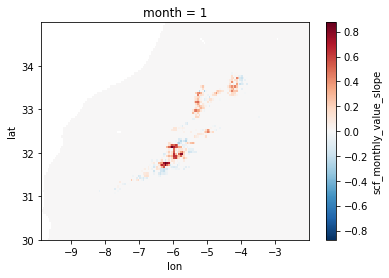

In [7]:
data_dic['ESA_ORIG']['scf_monthly_value'].loc[{'month':1}]['scf_monthly_value_slope'].transpose().plot()

<h1 style="font-size:1rem; color:green;"> climatological average </h1>

In [8]:
means_dic = {"ESA_ORIG":'data',"ESA_GF":'data',"ERA_LAND":'data', "SIM_35km":'data',"SIM_50km":'data',"SIM_250km":'data'}

In [9]:
for key in keys_dic:          
    means_dic[key] = xr.open_dataset(path_mean_data +'/'+key+'_based_average.nc')

In [10]:
for key in keys_dic:
    for par in parameters:
        aux1 = means_dic[key].to_dataframe()[par].reset_index()
        aux2 = data_dic[key][par].to_dataframe().reset_index()
        aux = pd.merge(aux1, aux2, how='inner', on=['lon', 'lat','month']).set_index(['lon', 'lat','month']).to_xarray()
        data_dic[key][par] = aux

<div class="alert alert-block alert-success"; background-color:red> We define the formatting function of the figures </div> 

In [11]:
# This auxiliary function will help us in the formatting of the figures
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

<div class="alert alert-block alert-success"; background-color:red> We personalize the colorbar </div> 

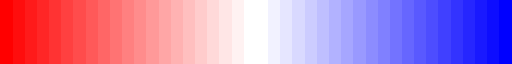

In [12]:
import matplotlib as mpl
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)    

c1='red' 
c2='white'
c3 = 'blue'
n=20

colors1 = []
colors2 = []


for x in range(n+1):
    colors1.append(colorFader(c1,c2,x/n))
    colors2.append(colorFader(c2,c3,x/n))

colors = colors1 + colors2
cmap_init = mpl.colors.ListedColormap(colors)
cmap_init 

<div class="alert alert-block alert-success"; background-color:red> We change the order of the keys of the dataset dictionary so that the low resolutions are on the left in the plots and the high resolutions are on the right </div> 

In [17]:
keys_dic = ["SIM_250km", "SIM_50km","SIM_35km","ERA_LAND", "ESA_ORIG" , "ESA_GF"]

<h1 style="font-size:2rem; color:green;"> Plots </h1>

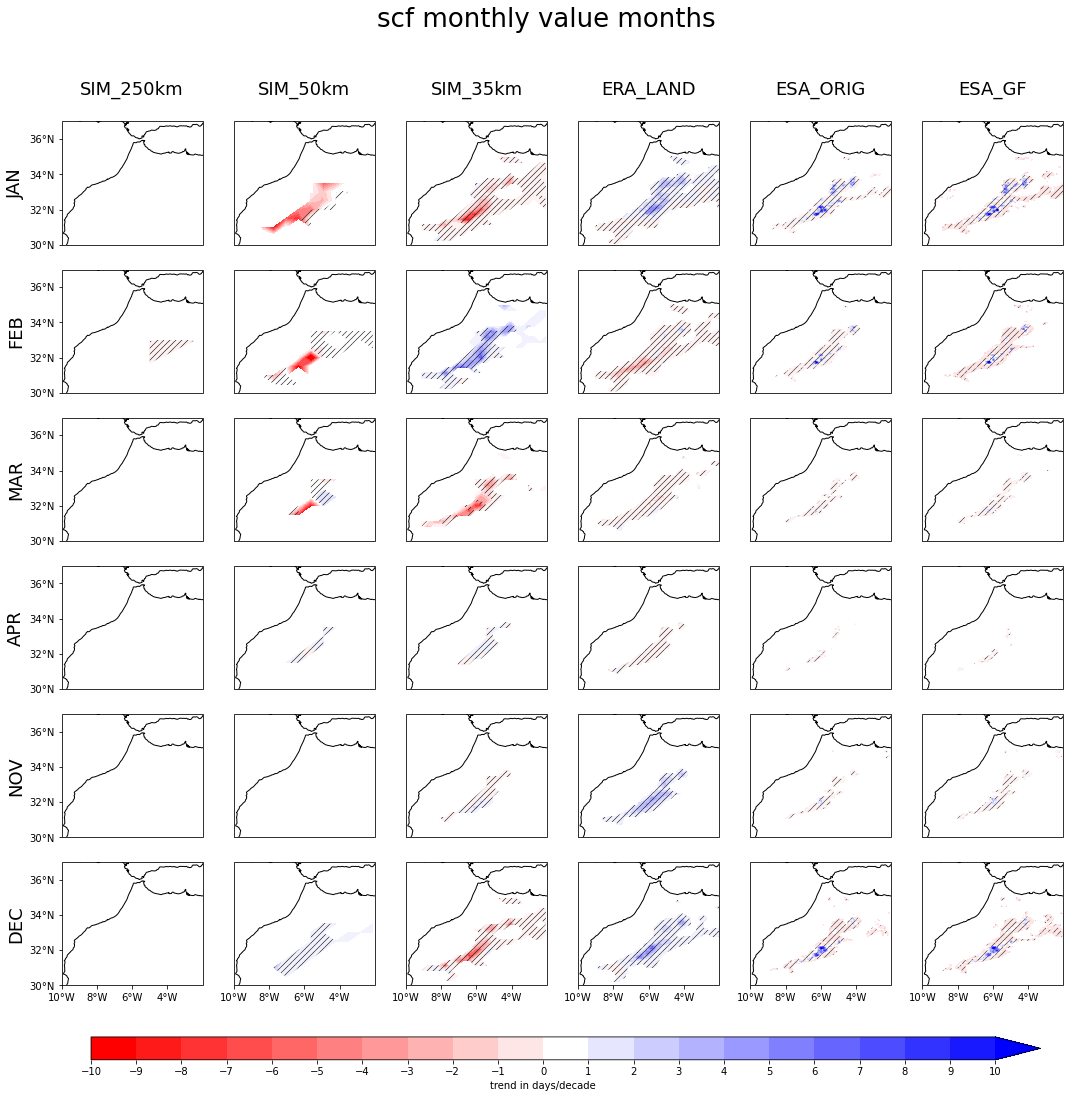

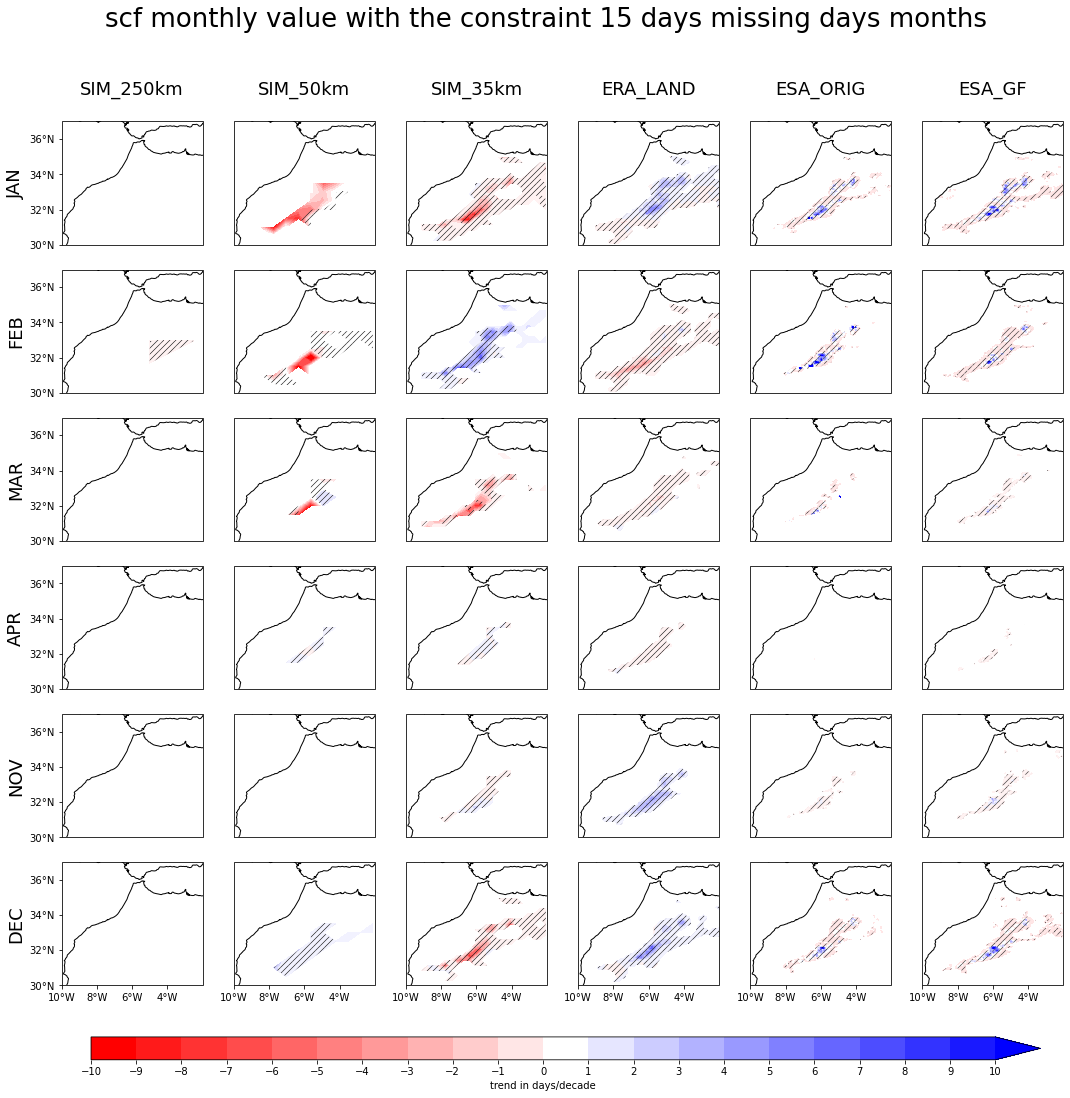

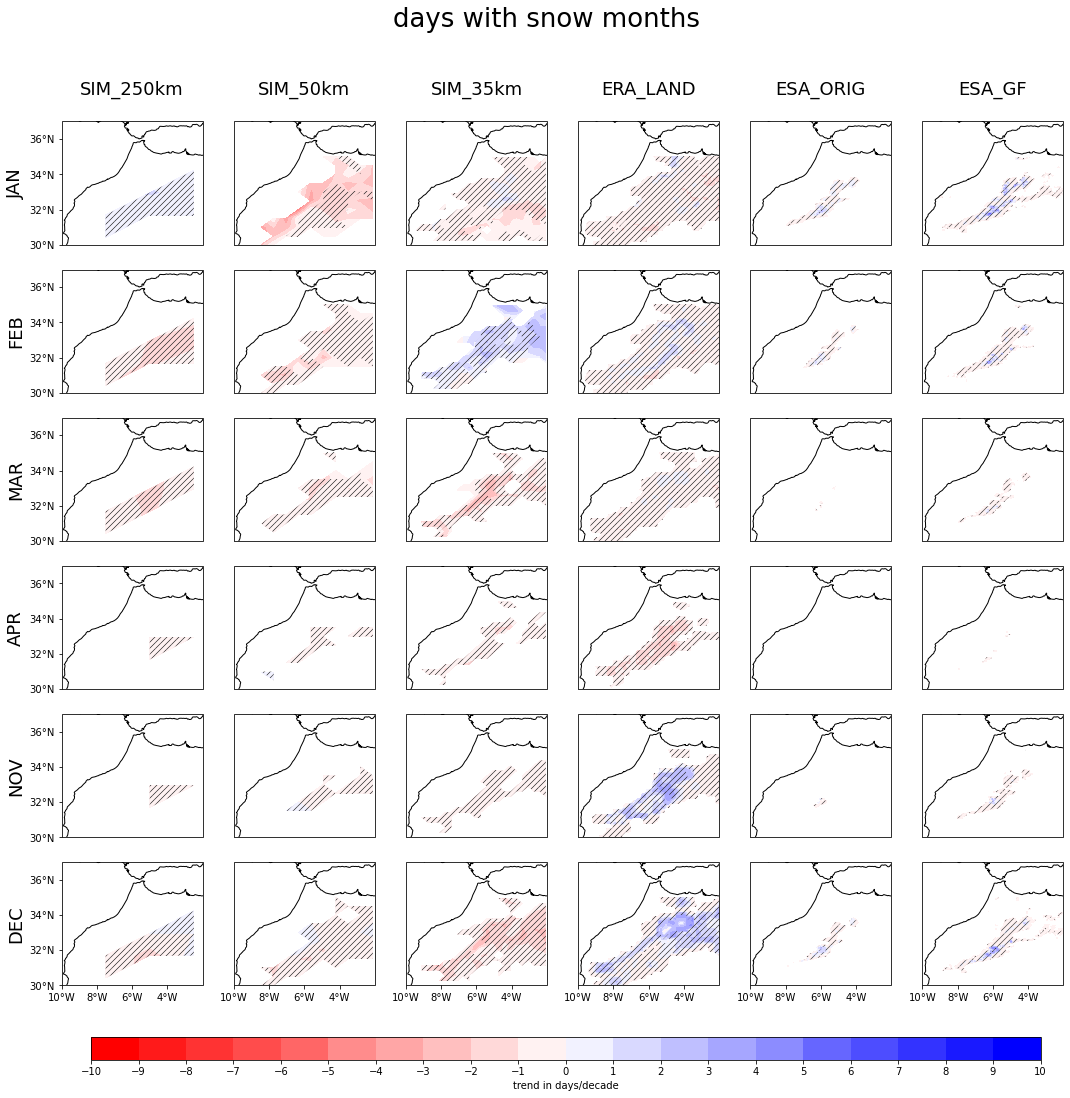

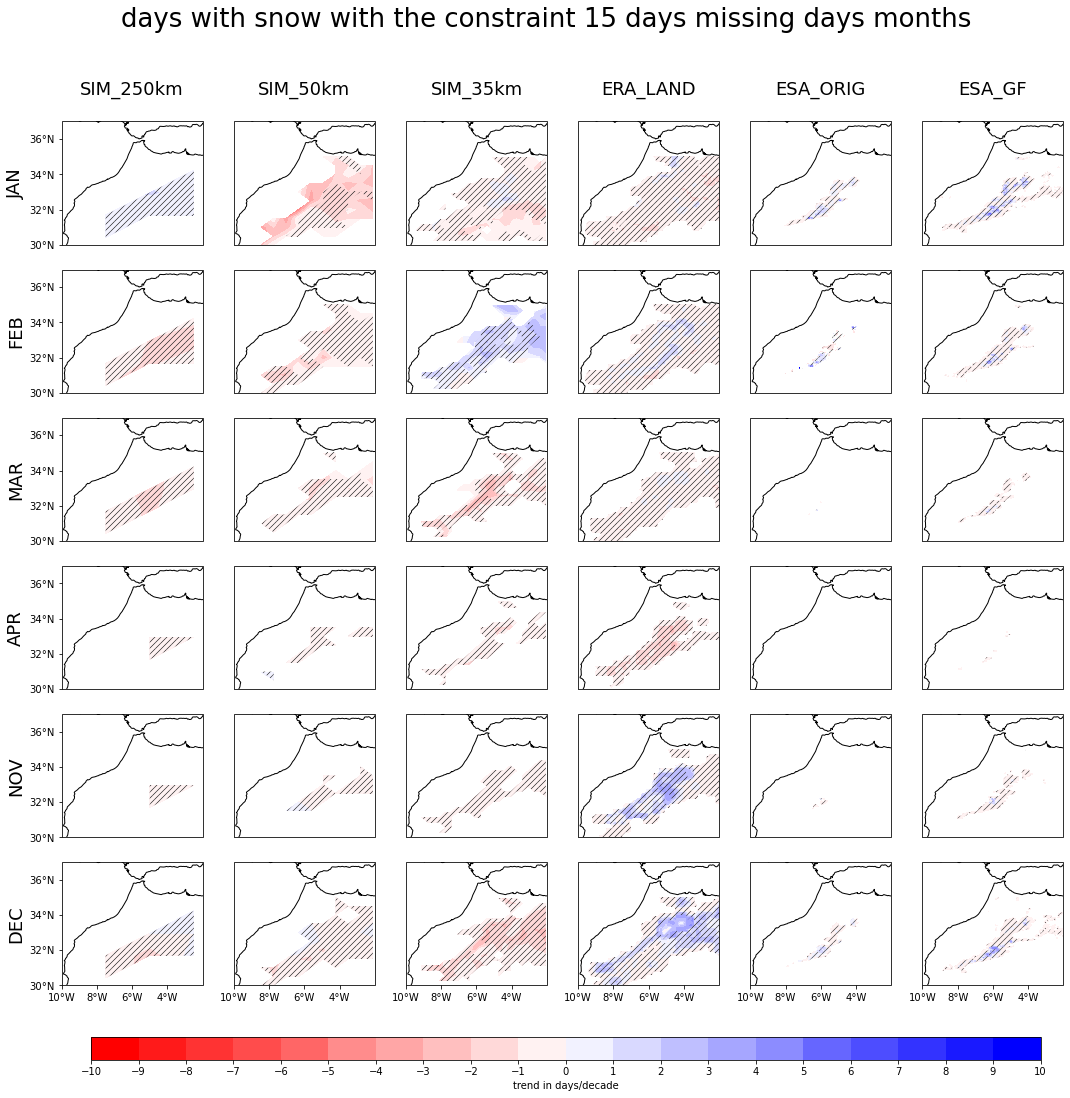

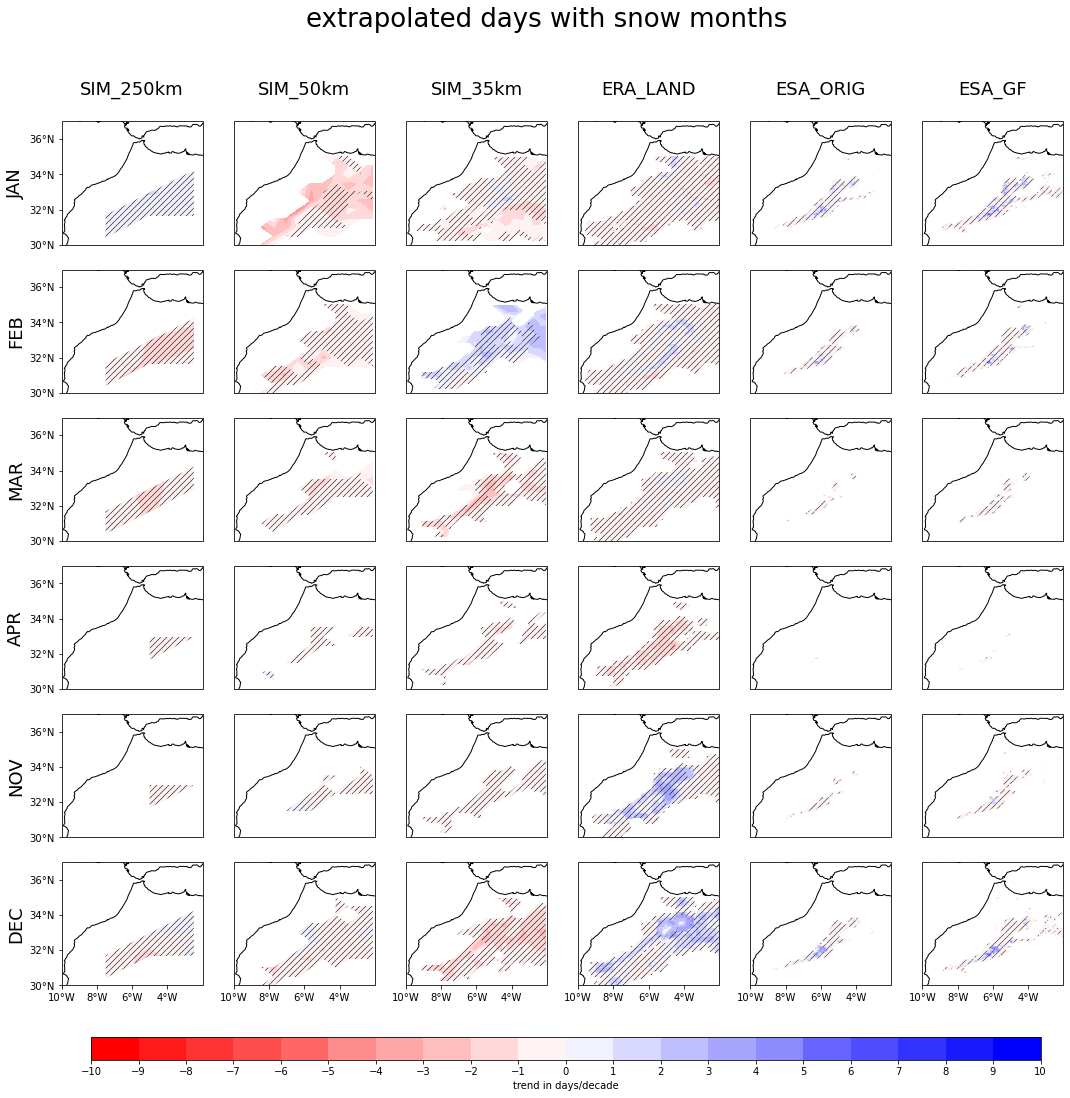

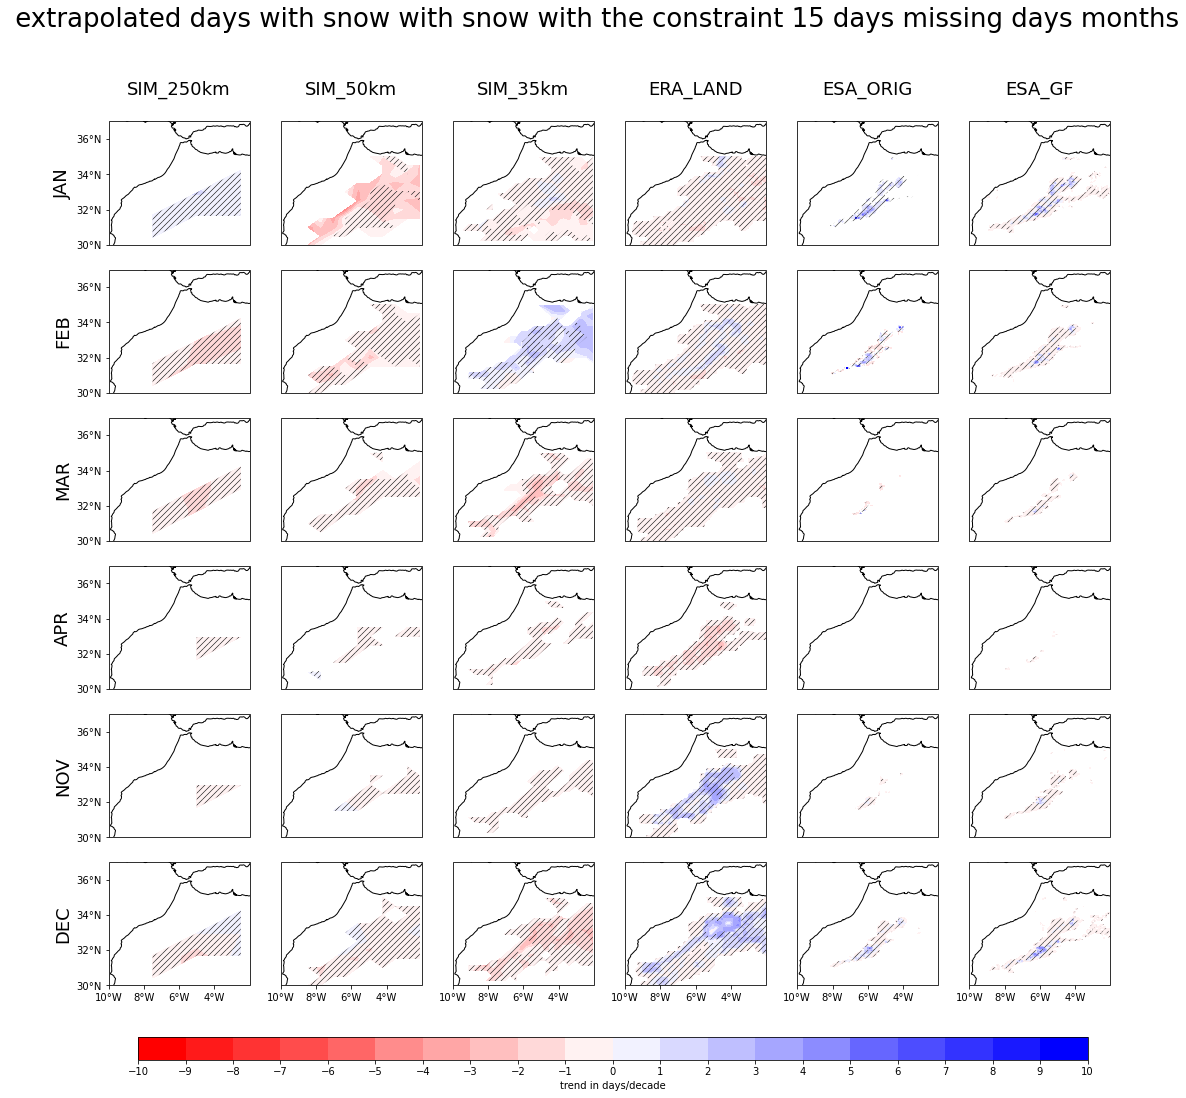

In [71]:
for ctr,par in enumerate(parameters):
    if ctr==2:
        scf_max_leg = 10
        scf_min_leg = -10
        leg_title_init = 'trend in days/decade'
        
    # Define the figure and each axis for the 3 rows and 3 columns
    fig, axs = plt.subplots(nrows=6,ncols=6,
                            subplot_kw={'projection': ccrs.PlateCarree()}) #   figsize=(11,8.5)
    plt.subplots_adjust(wspace=0.17,hspace=0.2)
    set_size(14,12) 

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    axs=axs.flatten()


    # Loop over all of the models
    i=0 
    j=0
    for mon in [1,2,3,4,11,12]: 
        for key in keys_dic:
            data=data_dic[key][par].loc[{'month':mon}] 
            data = data.where(data[par]>1)
            slope = data[par+'_slope']
            slope=slope*10
            pvalue = data[par+'_p']
            pvalue = pvalue.where(pvalue > 0.05)
     
            cs_slope = slope.transpose().plot.contourf(ax=axs[i], cmap=cmap_init, levels=np.linspace(scf_min_leg,scf_max_leg,scf_max_leg - scf_min_leg + 1), add_colorbar=False)
            pvalue.transpose().plot.contourf(ax = axs[i], hatches=['////'], alpha=0, add_colorbar=False)

            axs[i].set_extent([-10, -2, 30, 37]) 
        
            # Draw the coastines for each subplot
            axs[i].coastlines()

            axs[i].set_ylabel('',  fontsize=18)
            axs[i].set_title('',  fontsize=18)
        
            i=i+1        
        j=j+1

    
    # Longitude labels
    for i in range(30,36):
        axs[i].set_xticks(np.arange(-10,-2,2), crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    for i in range(0,31,6):
        axs[i].set_yticks(np.arange(30,37.5,2), crs=ccrs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
    
    k=0
    for i in range(30,36):
        axs[i].set_xlabel('',  fontsize=18)
        k=k+1
    
    k=0
    for i in range(0,31,6):
        axs[i].set_ylabel(wet_months_labels[k],  fontsize=18)
        k=k+1
 
    # Title each subplot with the name of the model 
    for i in range(6):
        axs[i].set_title(keys_dic[i]+'\n',  fontsize=18)
        

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.15, 0.06, 0.73, 0.02])

    # Draw the colorbar   
    fig.colorbar(cs_slope, cax=cbar_ax, cmap=cmap_init, label=leg_title_init,orientation='horizontal', ticks=np.linspace(scf_min_leg,scf_max_leg,scf_max_leg - scf_min_leg + 1)) # extend='right
    fig.suptitle(suptitles[par]+' months', fontsize=26)

<div class="alert alert-block alert-success"; background-color:red> We store figures </div> 

C:\Users\Hamid\anaconda3\lib\site-packages\matplotlib\contour.py:1486: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\Hamid\anaconda3\lib\site-packages\matplotlib\contour.py:1487: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\Hamid\anaconda3\lib\site-packages\matplotlib\contour.py:1486: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\Hamid\anaconda3\lib\site-packages\matplotlib\contour.py:1487: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\Hamid\anaconda3\lib\site-packages\matplotlib\contour.py:1486: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\Hamid\anaconda3\lib\site-packages\matplotlib\contour.py:1487: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


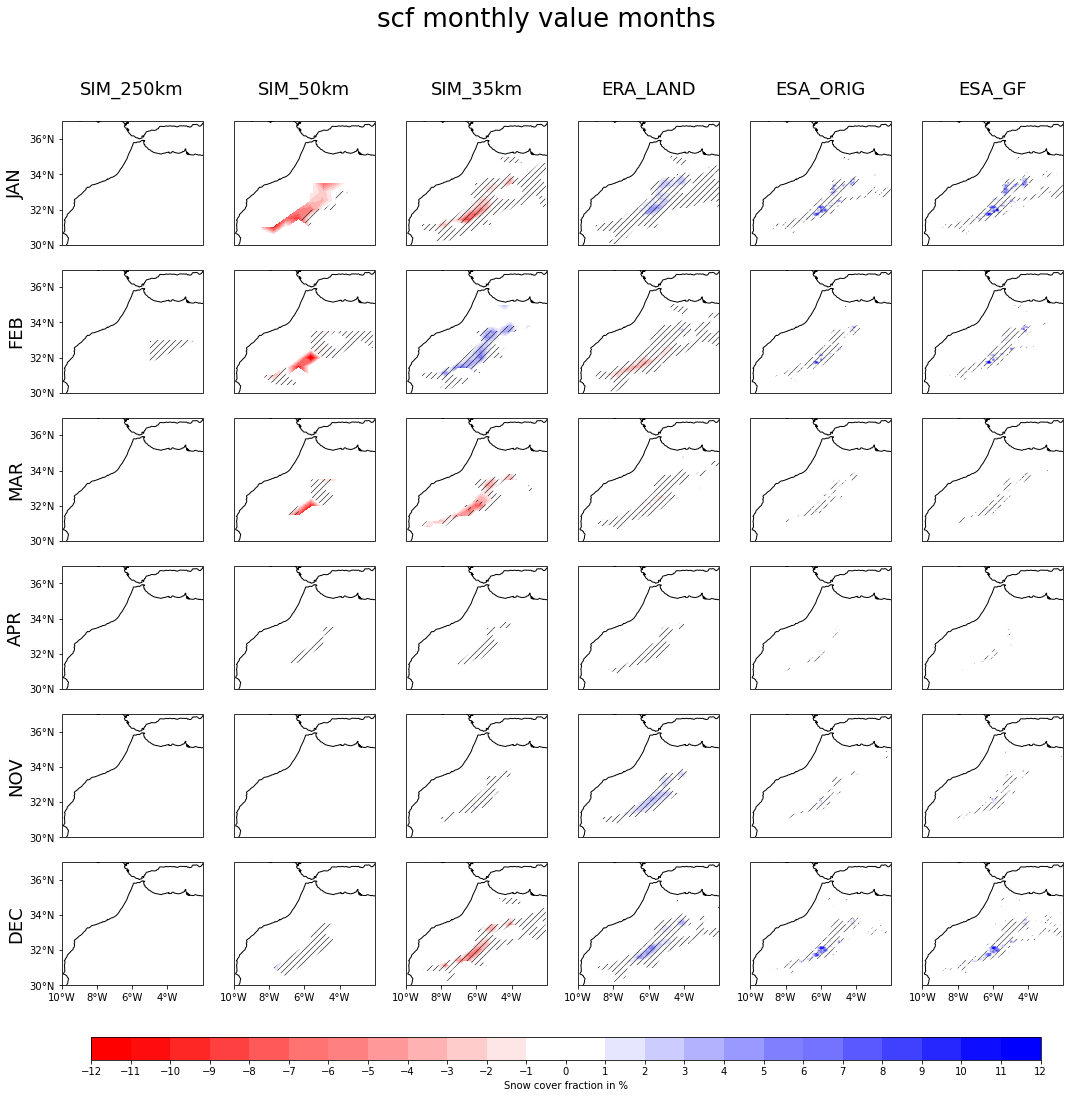

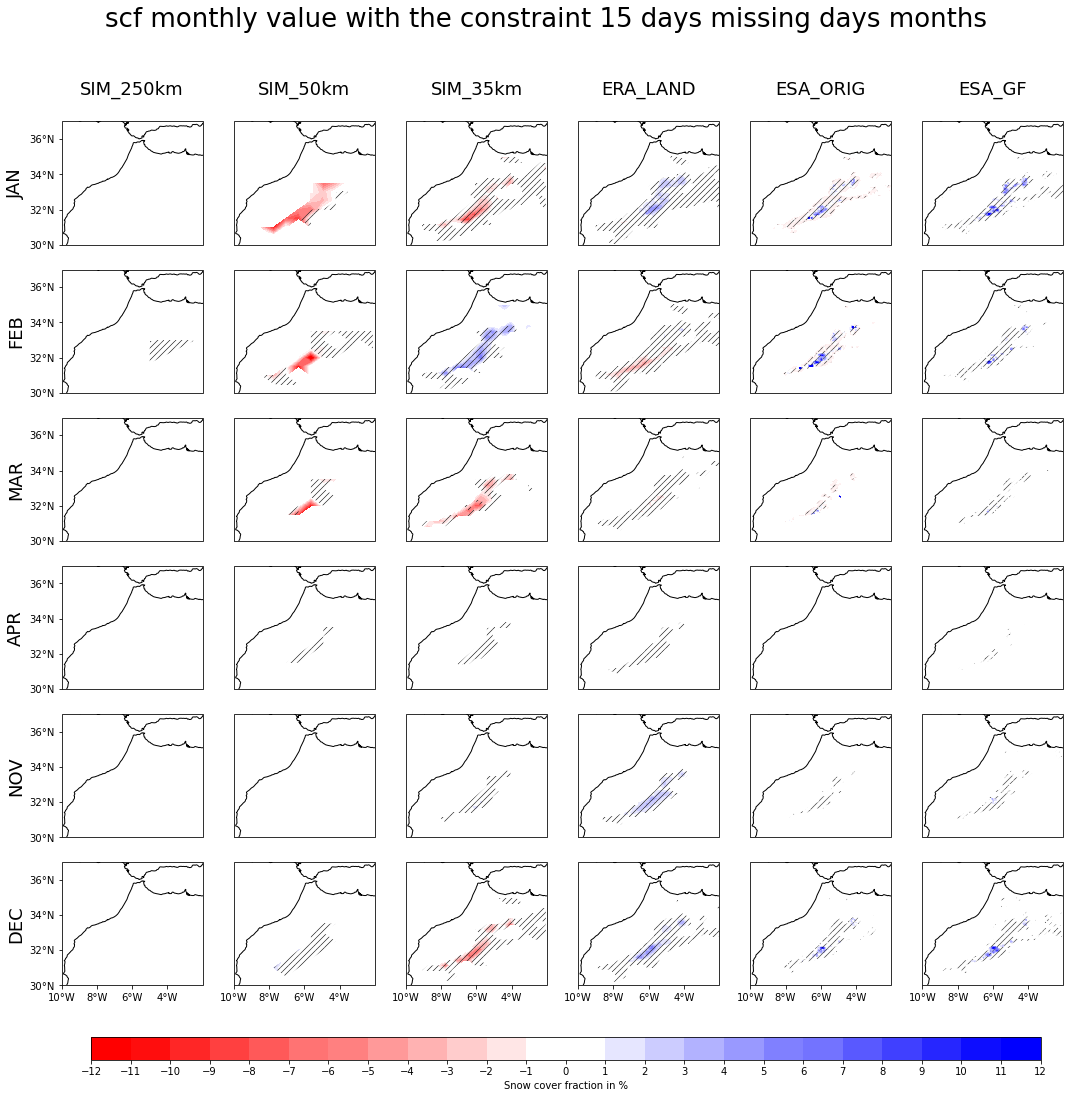

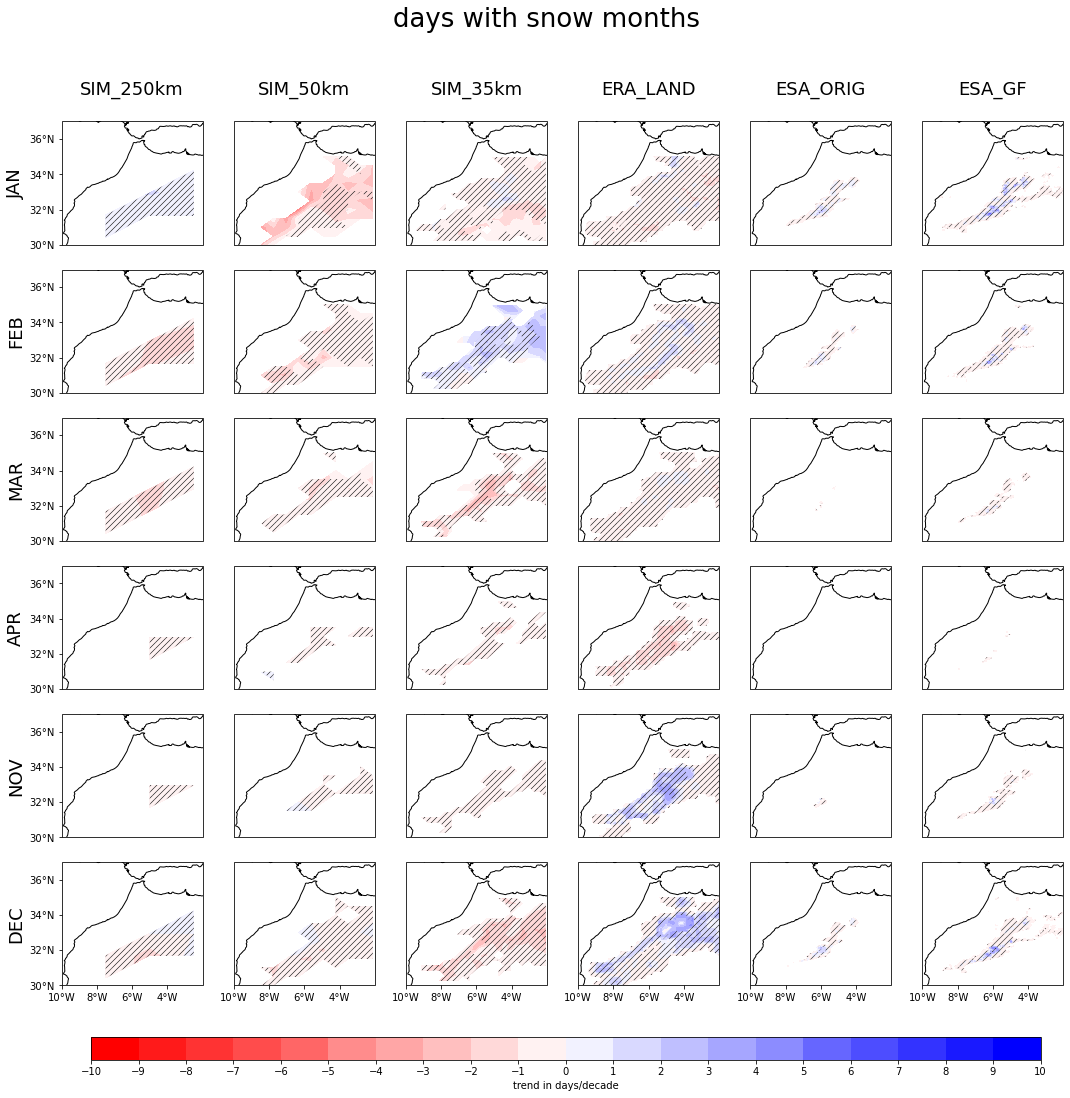

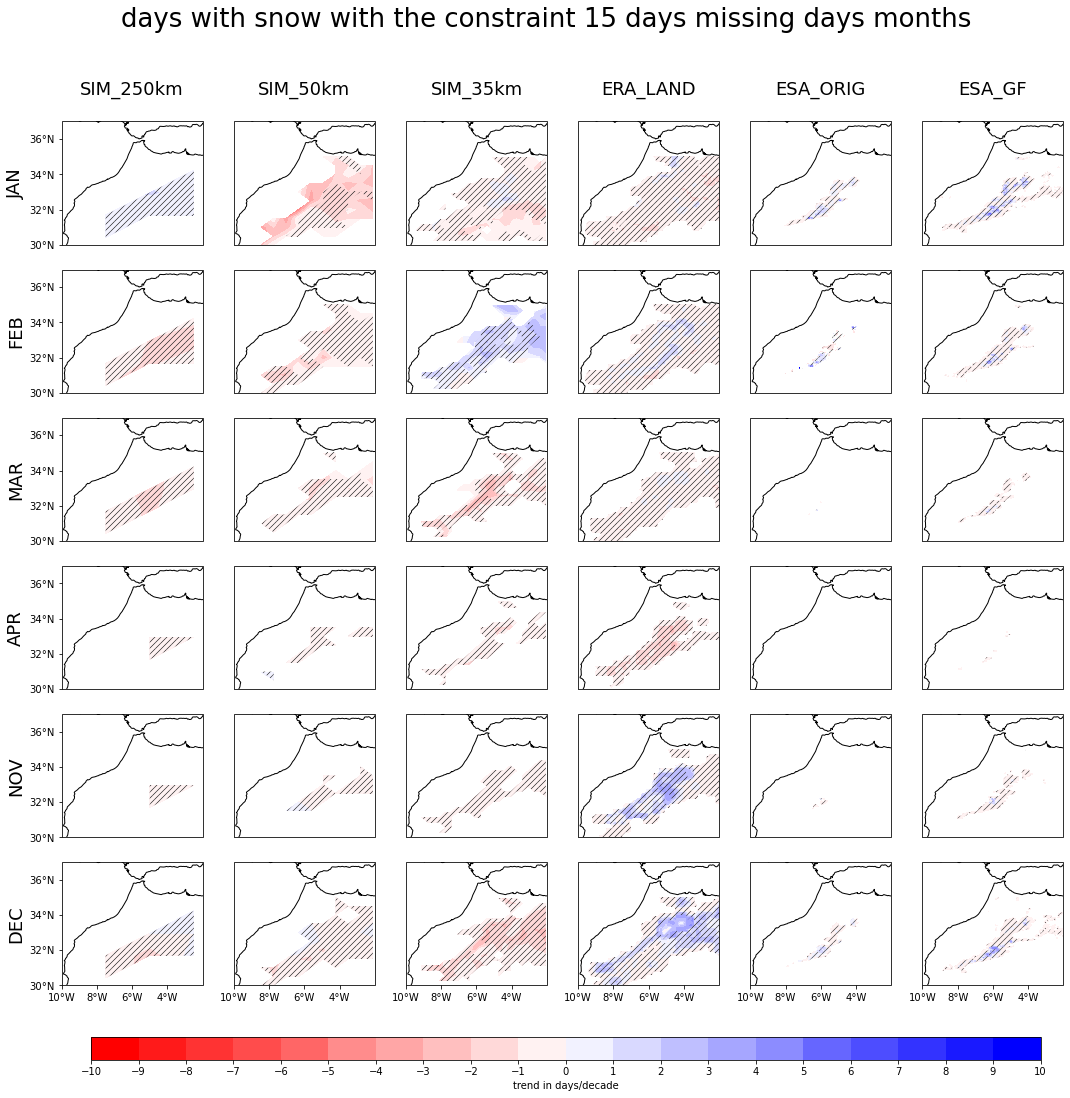

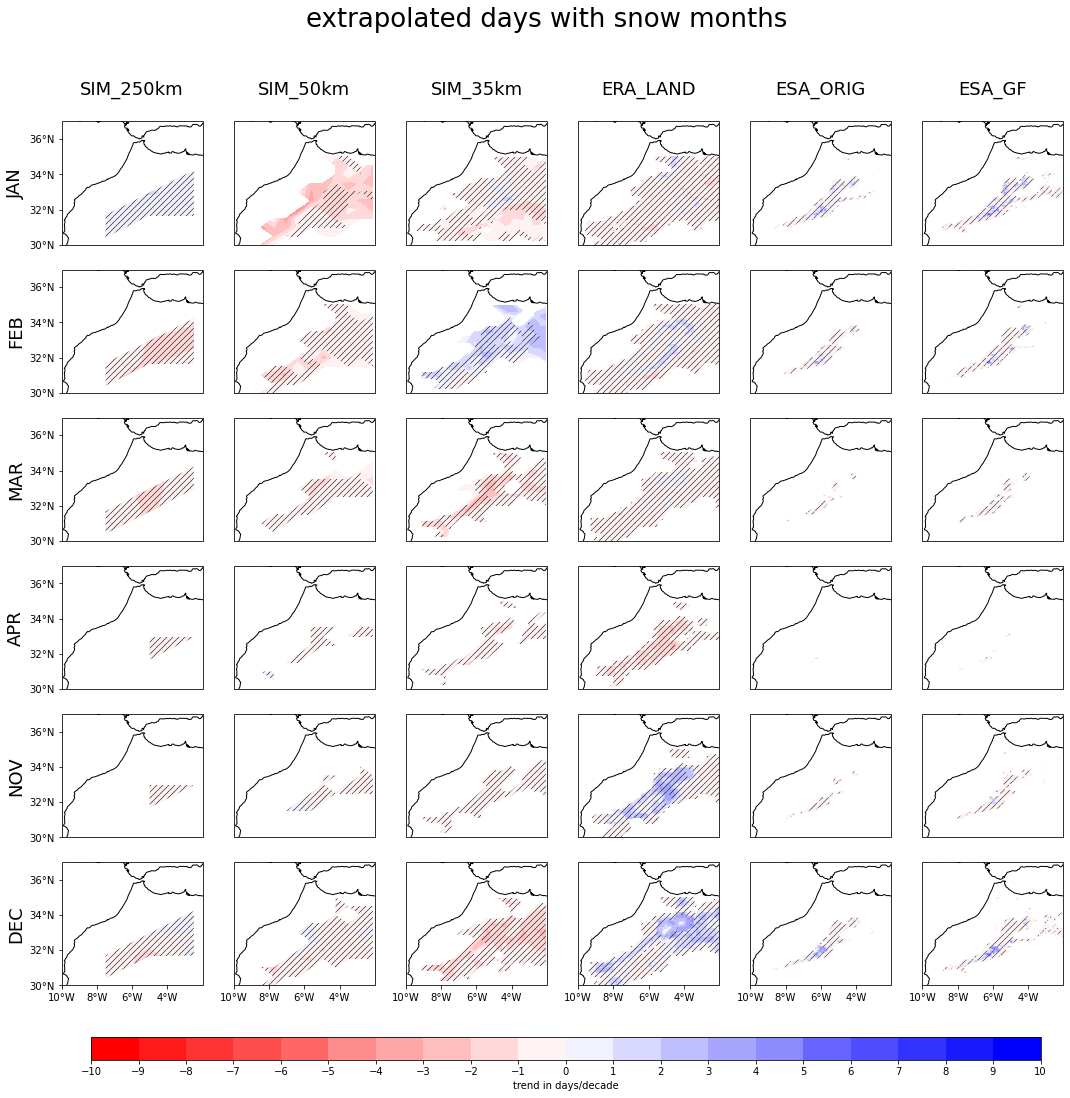

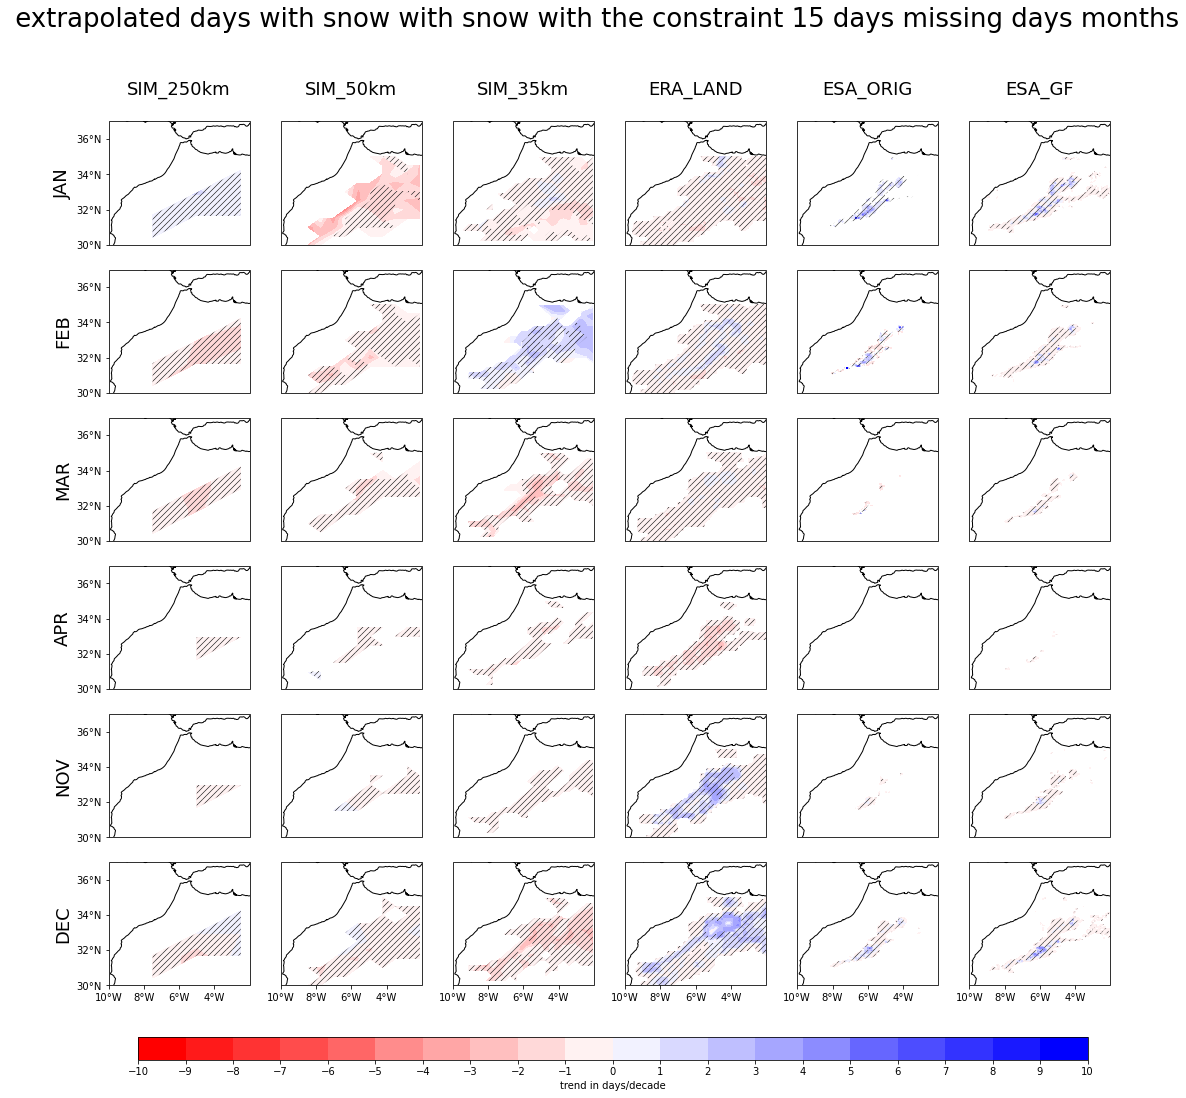

In [73]:
for ctr,par in enumerate(parameters):
    if ctr==2:
        scf_max_leg = 10
        scf_min_leg = -10
        leg_title_init = 'trend in days/decade'
        
    # Define the figure and each axis for the 3 rows and 3 columns
    fig, axs = plt.subplots(nrows=6,ncols=6,
                            subplot_kw={'projection': ccrs.PlateCarree()}) #   figsize=(11,8.5)
    plt.subplots_adjust(wspace=0.17,hspace=0.2)
    set_size(14,12) 

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    axs=axs.flatten()


    # Loop over all of the models
    i=0 
    j=0
    for mon in [1,2,3,4,11,12]: 
        for key in keys_dic:
            data=data_dic[key][par].loc[{'month':mon}] 
            data = data.where(data[par]>1)
            slope = data[par+'_slope']
            slope=slope*10
            pvalue = data[par+'_p']
            pvalue = pvalue.where(pvalue > 0.05)
     
            cs_slope = slope.transpose().plot.contourf(ax=axs[i], cmap=cmap_init, levels=np.linspace(scf_min_leg,scf_max_leg,scf_max_leg - scf_min_leg + 1), add_colorbar=False)
            pvalue.transpose().plot.contourf(ax = axs[i], hatches=['////'], alpha=0, add_colorbar=False)

            axs[i].set_extent([-10, -2, 30, 37]) 
        
            # Draw the coastines for each subplot
            axs[i].coastlines()

            axs[i].set_ylabel('',  fontsize=18)
            axs[i].set_title('',  fontsize=18)
        
            i=i+1        
        j=j+1

    
    # Longitude labels
    for i in range(30,36):
        axs[i].set_xticks(np.arange(-10,-2,2), crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    for i in range(0,31,6):
        axs[i].set_yticks(np.arange(30,37.5,2), crs=ccrs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
    
    k=0
    for i in range(30,36):
        axs[i].set_xlabel('',  fontsize=18)
        k=k+1
    
    k=0
    for i in range(0,31,6):
        axs[i].set_ylabel(wet_months_labels[k],  fontsize=18)
        k=k+1
 
    # Title each subplot with the name of the model 
    for i in range(6):
        axs[i].set_title(keys_dic[i]+'\n',  fontsize=18)
        

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.15, 0.06, 0.73, 0.02])

    # Draw the colorbar   
    fig.colorbar(cs_slope, cax=cbar_ax, cmap=cmap_init, label=leg_title_init,orientation='horizontal', ticks=np.linspace(scf_min_leg,scf_max_leg,scf_max_leg - scf_min_leg + 1)) # extend='right
    fig.suptitle(suptitles[par]+' months', fontsize=26)
    
    plt.savefig(output_path+'/'+par+'_trend_threshold_0.pdf') 

<h1 style="font-size:2rem; color:green;"> Some useful codes </h1>

In [ ]:
    
           
    # Adjust the location of the subplots on the page to make room for the colorbar
    # fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
    #                   wspace=0.02, hspace=0.02)
    
            
    #  Delete the unwanted axes     
    #  for i in [7,8]:    
    #  fig.delaxes(axs[i])  
